### Narwhal habitat model figures

In [73]:
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

### Import and format narwhal detection data

In [74]:
# import narwhal acoustic detection data
detections_dir = "H:/Habitat_model_data/narwhal_detections/"

# Kong Oscar 2018 data - AURAL
KO18_narwhal_aural_det = pd.read_csv(detections_dir + 'Kong_Oscar_2018-2019_AuralM2_daily.csv')

# Kong Oscar 2019 data - ST and AURAL
KO19_narwhal_ST_det    = pd.read_csv(detections_dir + 'Nuussuaq_KongOscar_ST_daily_wavTime.csv') # the wavTime file is actually UTC
KO19_narwhal_aural_det = pd.read_csv(detections_dir + 'Nuussuaq_KongOscar_AuralM2_daily.csv')

# Rink 2018 - AURAL
rink18_narwhal_aural_det = pd.read_csv(detections_dir + 'Rink_Glacier_2018-19_AuralM2_daily.csv')

# Fisher Islands/Rink - ST and AURAL
fisher19_narwhal_ST_det    = pd.read_csv(detections_dir + 'Rink_Glacier_Fischer_ST_daily.csv')
fisher19_narwhal_aural_det = pd.read_csv(detections_dir + 'Rink_Glacier_Fischer_AuralM2_daily.csv')

# Sverdrup - AURAL
sver18_narwhal_aural_det = pd.read_csv(detections_dir + 'Sverdrup2018-19_AuralM2_daily.csv')

In [75]:
def csv_to_datetime(detections_csv):
    date_time_str = detections_csv['Time_UTC'].tolist()
    dates = []
    for date in date_time_str:
        tmp = datetime.strptime(date, '%Y/%b/%d %H:%M:%S')
        dates.append(np.datetime64(tmp))
    dates_array = np.array(dates)
    return dates_array

### Import and format sea ice concentration data

From Harry: "Note that the sea-ice area has been rounded to the nearest sq km. Since each grid cell has an area of roughly 10 km^2, there's no point in keeping decimal places.

Following is the number of grid cells and their total area that contribute to the sea-ice area calculation:
- Sverdrup  53   533
- Kong Oscar  90   906
- Fisher Islands  94   947

In other words, there are 53 grid cells inside the Sverdrup circle that are used for calculating sea-ice area, and their total area is 533 km^2. So if we let A = the sea-ice area in Column 4 of the spreadsheet, then 100 x (A/533) is the percent of the area covered by sea ice. Similarly, to normalize Kong Oscar you would calculate 100 x (area/906) and for Fisher Islands it would be 100 x (area/947).

There are missing values in the time series at 2018-8-15 and 2018-12-16. For some reason there is no satellite data on those days. In the spreadsheet, you'll find a value of -100 for the sea-ice area on those days. So if you plot up the numbers, that's why you get two days with negative area!"

In [76]:
# import sea ice area data (from Harry Stern)
sea_ice_area = pd.read_csv('H:/Habitat_model_data/sea_ice_cover/Melville_sea_ice_area.csv')

In [77]:
# sea ice area (in square km for each circle with a 30 km radius around each mooring site)
# -100 is a filler, so replace these with np.nan
sver_ice   = pd.DataFrame(sea_ice_area['sverdrup']).replace(-100, np.nan)
ko_ice     = pd.DataFrame(sea_ice_area['kong_oscar']).replace(-100, np.nan)
fisher_ice = pd.DataFrame(sea_ice_area['fisher']).replace(-100, np.nan)

In [78]:
# then interpolate between neighboring values to fill nans
# calculate sea ice cover (%) from area
sver_ice_percent   = sver_ice.interpolate().iloc[:,0].to_numpy()/533*100
ko_ice_percent     = ko_ice.interpolate().iloc[:,0].to_numpy()/906*100
fisher_ice_percent = fisher_ice.interpolate().iloc[:,0].to_numpy()/947*100

In [79]:
# format time fields from csv
years  = np.array(sea_ice_area['year'])
months = np.array(sea_ice_area['month'])
days   = np.array(sea_ice_area['day'])

dates_list = []
for i in range(len(years)):
    if months[i] < 10: month_str = f'0{months[i]}'
    else: month_str = months[i]
    if days[i] < 10: day_str   = f'0{days[i]}'
    else: day_str = days[i]
    
    date_str = f'{years[i]}-{month_str}-{day_str}'
    dates_list.append(date_str)

dates_dt64 = np.array(dates_list, dtype='datetime64')

In [80]:
fisher_ice_df_1D = pd.DataFrame({'time': dates_dt64, 'ice_cover_percent': fisher_ice_percent})
ko_ice_df_1D     = pd.DataFrame({'time': dates_dt64, 'ice_cover_percent': ko_ice_percent})
sver_ice_df_1D   = pd.DataFrame({'time': dates_dt64, 'ice_cover_percent': sver_ice_percent})

In [81]:
## extract dates for sea ice freeze-up
## 2018
print(fisher_ice_df_1D[fisher_ice_df_1D['time']==pd.to_datetime('2018-11-13')])
print(ko_ice_df_1D[ko_ice_df_1D['time']==pd.to_datetime('2018-11-13')])
print(sver_ice_df_1D[sver_ice_df_1D['time']==pd.to_datetime('2018-10-28')],'\n')

## 2019
print(fisher_ice_df_1D[fisher_ice_df_1D['time']==pd.to_datetime('2019-12-23')])
print(ko_ice_df_1D[ko_ice_df_1D['time']==pd.to_datetime('2019-12-31')])
print(sver_ice_df_1D[sver_ice_df_1D['time']==pd.to_datetime('2019-12-30')])

          time  ice_cover_percent
104 2018-11-13          95.881732
          time  ice_cover_percent
104 2018-11-13          93.598234
         time  ice_cover_percent
88 2018-10-28          87.804878 

          time  ice_cover_percent
509 2019-12-23          90.813094
          time  ice_cover_percent
517 2019-12-31          87.748344
          time  ice_cover_percent
516 2019-12-30          90.994371


#### Kong Oscar

In [82]:
KO18_aural_dates_array = csv_to_datetime(KO18_narwhal_aural_det)
KO18_aural_narwhal_det_array = KO18_narwhal_aural_det['narwhal'].to_numpy()

KO18_aural_narwhal_dates = KO18_aural_dates_array[KO18_aural_narwhal_det_array == 1] # identify dates when narwhal were detected

In [86]:
def csv_to_datetime(detections_csv):
    date_time_str = detections_csv['Time_wav'].tolist()
    dates = []
    for date in date_time_str:
        tmp = datetime.strptime(date, '%Y/%b/%d %H:%M:%S')
        dates.append(np.datetime64(tmp))
    dates_array = np.array(dates)
    return dates_array

In [87]:
KO19_ST_dates_array = csv_to_datetime(KO19_narwhal_ST_det)
KO19_ST_narwhal_det_array = KO19_narwhal_ST_det['narwhal'].to_numpy()

KO19_ST_narwhal_dates = KO19_ST_dates_array[KO19_ST_narwhal_det_array == 1] # identify dates when narwhal were detected

In [89]:
def csv_to_datetime(detections_csv):
    date_time_str = detections_csv['Time_UTC'].tolist()
    dates = []
    for date in date_time_str:
        tmp = datetime.strptime(date, '%Y/%b/%d %H:%M:%S')
        dates.append(np.datetime64(tmp))
    dates_array = np.array(dates)
    return dates_array

In [90]:
KO19_aural_dates_array = csv_to_datetime(KO19_narwhal_aural_det)
KO19_aural_narwhal_det_array = KO19_narwhal_aural_det['narwhal'].to_numpy()

KO19_aural_narwhal_dates = KO19_aural_dates_array[KO19_aural_narwhal_det_array == 1] # identify dates when narwhal were detected

#### Rink

In [91]:
rink_aural_dates_array = csv_to_datetime(rink18_narwhal_aural_det)
rink_aural_narwhal_det_array = rink18_narwhal_aural_det['narwhal'].to_numpy()

rink_aural_narwhal_dates = rink_aural_dates_array[rink_aural_narwhal_det_array == 1] # identify dates when narwhal were detected

#### Fisher Islands

In [92]:
fisher_ST_dates_array = csv_to_datetime(fisher19_narwhal_ST_det)
fisher_ST_narwhal_det_array = fisher19_narwhal_ST_det['narwhal'].to_numpy()

fisher_ST_narwhal_dates = fisher_ST_dates_array[fisher_ST_narwhal_det_array == 1] # identify dates when narwhal were detected

In [93]:
fisher_aural_dates_array = csv_to_datetime(fisher19_narwhal_aural_det)
fisher_aural_narwhal_det_array = fisher19_narwhal_aural_det['narwhal'].to_numpy()

fisher_aural_narwhal_dates = fisher_aural_dates_array[fisher_aural_narwhal_det_array == 1] # identify dates when narwhal were detected

#### Sverdrup

In [94]:
sver18_aural_dates_array = csv_to_datetime(sver18_narwhal_aural_det)
sver18_aural_narwhal_det_array = sver18_narwhal_aural_det['narwhal'].to_numpy()

sver18_aural_narwhal_dates = sver18_aural_dates_array[sver18_aural_narwhal_det_array == 1] # identify dates when narwhal were detected

#### Import runoff data

In [95]:
runoff_dir = 'H:/Habitat_model_data/covariate_csv_files/runoff/'

runoff_mar_kong = pd.read_csv(runoff_dir + 'kongoscar_runoff_mar_1D.csv')
runoff_racmo_kong = pd.read_csv(runoff_dir + 'kongoscar_runoff_racmo_1D.csv')
runoff_mar_rink = pd.read_csv(runoff_dir + 'rink_runoff_mar_1D.csv')
runoff_racmo_rink = pd.read_csv(runoff_dir + 'rink_runoff_racmo_1D.csv')
runoff_mar_sver = pd.read_csv(runoff_dir + 'sverdrup_runoff_mar_1D.csv')
runoff_racmo_sver = pd.read_csv(runoff_dir + 'sverdrup_runoff_racmo_1D.csv')

### Plot narwhal detections with sea ice and runoff data

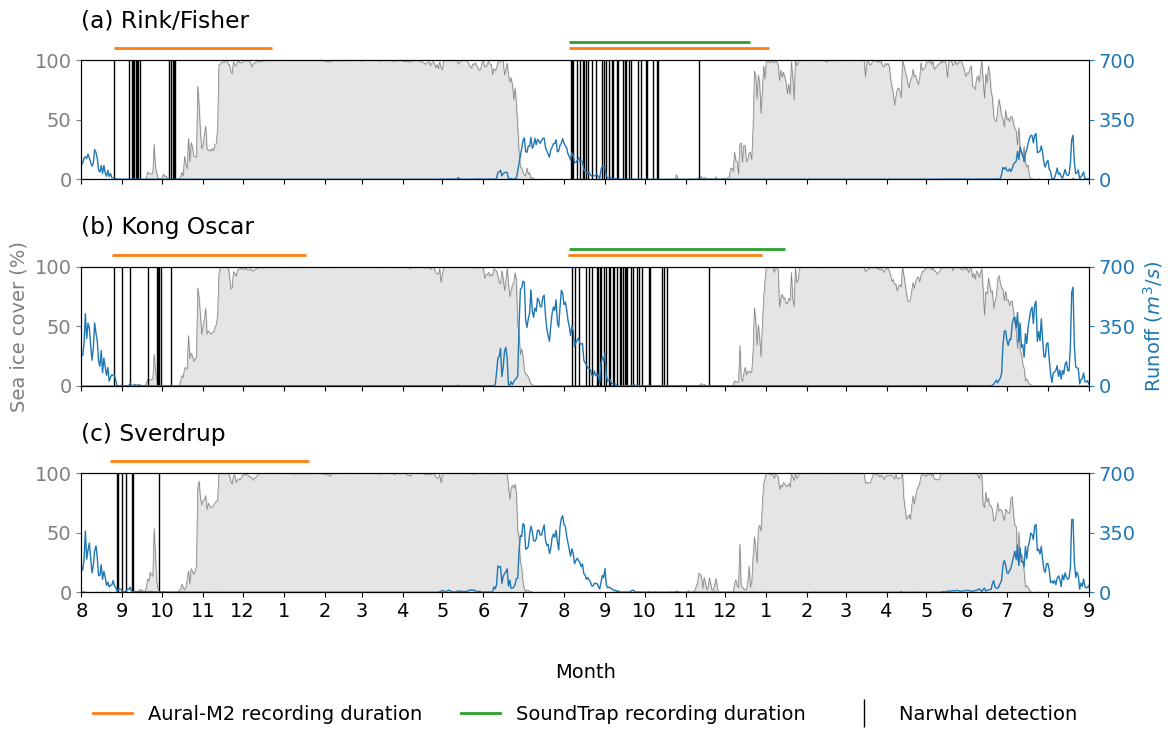

In [112]:
plt.rcParams["figure.figsize"] = (13,4)
plt.rcParams['font.size'] = 14
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8) = plt.subplots(8, sharex=True, sharey=False, gridspec_kw={'height_ratios': [0.6,6,2,0.6,6,2,0.6,6]})
# fig.suptitle('Sea Ice Cover in Melville Bay Fjords')

plt.subplots_adjust(top=1.5, hspace=0.2)
ax1.set_xlim(np.datetime64('2018-08-01'), np.datetime64('2020-09-01'))

# RINK/FISHER ====
ax1.set_title("(a) Rink/Fisher", loc='left')
ax1.hlines(y=0, xmin=rink_aural_dates_array[0], xmax=rink_aural_dates_array[-1],linewidth=2, color='tab:orange', clip_on=False)
ax1.hlines(y=0, xmin=fisher_aural_dates_array[0], xmax=fisher_aural_dates_array[-1],linewidth=2, color='tab:orange', clip_on=False)
ax1.hlines(y=50, xmin=fisher_ST_dates_array[0], xmax=np.datetime64('2019-12-20'),linewidth=2, color='tab:green', clip_on=False)
ax1.set_ylim(0,100)
ax1.axis('off')

ax2.plot(dates_dt64, fisher_ice_percent, 'tab:gray', linewidth=0.5)
ax2.fill_between(dates_dt64, 0, fisher_ice_percent, color='tab:gray', alpha=0.2)
ax2.tick_params(axis='y', colors='tab:gray')
# ax2.grid(linestyle='--', linewidth=0.5)
ax2.margins(x=0,y=0)

# add narwhal detections ----
for xcoord in rink_aural_narwhal_dates:
    ax2.axvline(x=xcoord, color='k', linewidth=1)
# for xcoord in fisher_aural_narwhal_dates:
#     ax2.axvline(x=xcoord, color='k', linewidth=1)
for xcoord in fisher_ST_narwhal_dates:
    ax2.axvline(x=xcoord, color='k', linewidth=1)
    
# add runoff - RACMO
ax2_twin = ax2.twinx()  
ax2_twin.plot(np.array(runoff_racmo_rink['time'], dtype='datetime64'), runoff_racmo_rink['runoff'].values, 'tab:blue', linewidth=1)

# KONG OSCAR ====
ax3.axis('off') # filler axis
ax4.set_title("(b) Kong Oscar", loc='left')
ax4.hlines(y=0, xmin=KO18_aural_dates_array[0], xmax=KO18_aural_dates_array[-1], linewidth=2, color='tab:orange', clip_on=False, label='Aural start/end')
ax4.hlines(y=0, xmin=KO19_aural_dates_array[0], xmax=KO19_aural_dates_array[-1], linewidth=2, color='tab:orange', clip_on=False, label='Aural start/end')
ax4.hlines(y=50, xmin=KO19_ST_dates_array[0], xmax=KO19_ST_dates_array[-1], linewidth=2, color='tab:green', clip_on=False, label='SoundTrap start/end')
ax4.set_ylim(0,100)
ax4.axis('off')

ax5.plot(dates_dt64, ko_ice_percent, 'tab:gray', linewidth=0.5)
ax5.fill_between(dates_dt64, 0, ko_ice_percent, color='tab:gray', alpha=0.2)
# ax5.set_ylabel("Sea Ice Cover (%)", color='tab:gray')
ax5.set_ylabel("Sea ice cover (%)", color='tab:gray')
ax5.tick_params(axis='y', colors='tab:gray')
ax5.margins(x=0,y=0)

# add narwhal detections ----
for xcoord in KO18_aural_narwhal_dates:
    ax5.axvline(x=xcoord, color='k', linewidth=1)
for xcoord in KO19_ST_narwhal_dates:
    ax5.axvline(x=xcoord, color='k', linewidth=1)
# for xcoord in KO19_aural_narwhal_dates:
#     ax5.axvline(x=xcoord, color='tab:blue', linewidth=1)
    
# add runoff - RACMO
ax5_twin = ax5.twinx()  
ax5_twin.plot(np.array(runoff_racmo_kong['time'], dtype='datetime64'), runoff_racmo_kong['runoff'].values, 'tab:blue', linewidth=1)
ax5_twin.set_ylabel("Runoff ($m^3/s$)", color='tab:blue')

# SVERDRUP ====
ax6.axis('off') # filler axis
ax7.set_title("(c) Sverdrup", loc='left')
ax7.hlines(y=0, xmin=sver18_aural_dates_array[0], xmax=sver18_aural_dates_array[-1], linewidth=2, color='tab:orange', clip_on=False, label='Aural start/end')
ax7.set_ylim(0,100)
ax7.axis('off')

# add narwhal detections ----
for xcoord in sver18_aural_narwhal_dates:
    ax8.axvline(x=xcoord, color='k', linewidth=1)
ax8.plot(dates_dt64, sver_ice_percent, 'tab:gray', linewidth=0.5)
ax8.fill_between(dates_dt64, 0, sver_ice_percent, color='tab:gray', alpha=0.2)
ax8.tick_params(axis='y', colors='tab:gray')
ax8.margins(x=0,y=0)

# add runoff - RACMO
ax8_twin = ax8.twinx()  
ax8_twin.plot(np.array(runoff_racmo_sver['time'], dtype='datetime64'), runoff_racmo_sver['runoff'].values, 'tab:blue', linewidth=1)

months   = pd.period_range(np.datetime64('2018-08'), freq='M', periods=26).strftime('%Y-%m').tolist()
# abbrev = ["A","S","O",'N','D',"J",'F','M','A','M','J','J','A',"S","O",'N','D',"J",'F','M','A','M','J','J','A',"S"]
abbrev = ['8','9','10','11','12','1','2','3','4','5','6','7','8','9','10','11','12','1','2','3','4','5','6','7','8','9']
ax8.set_xticks(months, [])
ax8.set_xticks(months, abbrev, rotation=0, horizontalalignment = 'center')

# add legend
legend_elements = [Line2D([0], [0], color='tab:orange', lw=2, label='Aural-M2 recording duration'),
                   Line2D([0], [0], color='tab:green', lw=2, label='SoundTrap recording duration'),
                   Line2D([], [], marker='|', linestyle='None',color='k', lw=1,markersize=20, label='Narwhal detection')]
ax8.legend(handles=legend_elements, loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.8),frameon=False)

# params for y-axis
for ax in (ax2_twin,ax5_twin,ax8_twin):
    ax.set_yticks([0,350,700])
    ax.margins(x=0,y=0)
    ax.set_ylim(0,700)
    ax.tick_params(axis='y', colors='tab:blue')

ax8.set_xlabel("Month",labelpad=30);

plt.savefig('figures/narwhal-dets_sea-ice_runoff.png', bbox_inches='tight', dpi=300, facecolor='white')

***

### Plot narwhal detections with temperature and salinity

Open DataArrays with interpolated temperature and salinity profiles

In [99]:
file_dir = Path('H:/PhD_chap3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_interpolated/')

In [100]:
# open Rink data
rink_temp_da_interp = xr.open_dataset(file_dir / "OMG_Narwhals_Mooring_Rink_1D_interpolated_temp_profile.nc")
rink_temp_da_interp.close()
rink_salt_da_interp = xr.open_dataset(file_dir / "OMG_Narwhals_Mooring_Rink_1D_interpolated_salt_profile.nc")
rink_salt_da_interp.close()

In [101]:
# open Fisher Islands data
fisher_temp_da_interp = xr.open_dataset(file_dir / "OMG_Narwhals_Mooring_Fisher_1D_interpolated_temp_profile.nc")
fisher_temp_da_interp.close()
fisher_salt_da_interp = xr.open_dataset(file_dir / "OMG_Narwhals_Mooring_Fisher_1D_interpolated_salt_profile.nc")
fisher_salt_da_interp.close()

In [102]:
# open Kong Oscar data
kongoscar_temp_da_interp = xr.open_dataset(file_dir / "OMG_Narwhals_Mooring_KongOscar_1D_interpolated_temp_profile.nc")
kongoscar_temp_da_interp.close()
kongoscar_salt_da_interp = xr.open_dataset(file_dir / "OMG_Narwhals_Mooring_KongOscar_1D_interpolated_salt_profile.nc")
kongoscar_salt_da_interp.close()

In [103]:
# open Sverdrup data
sverdrup_temp_da_interp = xr.open_dataset(file_dir / "OMG_Narwhals_Mooring_Sverdrup_1D_interpolated_temp_profile.nc")
sverdrup_temp_da_interp.close()
sverdrup_salt_da_interp = xr.open_dataset(file_dir / "OMG_Narwhals_Mooring_Sverdrup_1D_interpolated_salt_profile.nc")
sverdrup_salt_da_interp.close()

***

In [104]:
# 120-140 m

# temperature
rink_temp_120m_timeseries_da     = rink_temp_da_interp.temperature.sel(depth=slice(120,140)).mean(dim='depth', skipna=True)
fisher_temp_120m_timeseries_da   = fisher_temp_da_interp.temperature.sel(depth=slice(120,140)).mean(dim='depth', skipna=True)
sverdrup_temp_120m_timeseries_da = sverdrup_temp_da_interp.temperature.sel(depth=slice(120,140)).mean(dim='depth', skipna=True)
KO_temp_120m_timeseries_da       = kongoscar_temp_da_interp.temperature.sel(depth=slice(120,140)).mean(dim='depth', skipna=True)

# salinity
rink_salt_120m_timeseries_da     = rink_salt_da_interp.salinity.sel(depth=slice(120,140)).mean(dim='depth', skipna=True)
fisher_salt_120m_timeseries_da   = fisher_salt_da_interp.salinity.sel(depth=slice(120,140)).mean(dim='depth', skipna=True)
sverdrup_salt_120m_timeseries_da = sverdrup_salt_da_interp.salinity.sel(depth=slice(120,140)).mean(dim='depth', skipna=True)
KO_salt_120m_timeseries_da       = kongoscar_salt_da_interp.salinity.sel(depth=slice(120,140)).mean(dim='depth', skipna=True)

In [105]:
# 220-240 m

# temperature
rink_temp_220m_timeseries_da     = rink_temp_da_interp.temperature.sel(depth=slice(220,240)).mean(dim='depth', skipna=True)
fisher_temp_220m_timeseries_da   = fisher_temp_da_interp.temperature.sel(depth=slice(220,240)).mean(dim='depth', skipna=True)
sverdrup_temp_220m_timeseries_da = sverdrup_temp_da_interp.temperature.sel(depth=slice(220,240)).mean(dim='depth', skipna=True)
KO_temp_220m_timeseries_da       = kongoscar_temp_da_interp.temperature.sel(depth=slice(220,240)).mean(dim='depth', skipna=True)

# salinity
rink_salt_220m_timeseries_da     = rink_salt_da_interp.salinity.sel(depth=slice(220,240)).mean(dim='depth', skipna=True)
fisher_salt_220m_timeseries_da   = fisher_salt_da_interp.salinity.sel(depth=slice(220,240)).mean(dim='depth', skipna=True)
sverdrup_salt_220m_timeseries_da = sverdrup_salt_da_interp.salinity.sel(depth=slice(220,240)).mean(dim='depth', skipna=True)
KO_salt_220m_timeseries_da       = kongoscar_salt_da_interp.salinity.sel(depth=slice(220,240)).mean(dim='depth', skipna=True)

***

In [106]:
# 120-140 m

# temperature
rink_temp_120m_timeseries_da     = rink_temp_da_interp.temperature.sel(depth=slice(120,140)).mean(dim='depth', skipna=True)
sverdrup_temp_120m_timeseries_da = sverdrup_temp_da_interp.temperature.sel(depth=slice(120,140)).mean(dim='depth', skipna=True)
KO_temp_120m_timeseries_da       = kongoscar_temp_da_interp.temperature.sel(depth=slice(120,140)).mean(dim='depth', skipna=True)

# salinity
rink_salt_120m_timeseries_da     = rink_salt_da_interp.salinity.sel(depth=slice(120,140)).mean(dim='depth', skipna=True)
sverdrup_salt_120m_timeseries_da = sverdrup_salt_da_interp.salinity.sel(depth=slice(120,140)).mean(dim='depth', skipna=True)
KO_salt_120m_timeseries_da       = kongoscar_salt_da_interp.salinity.sel(depth=slice(120,140)).mean(dim='depth', skipna=True)

In [107]:
# 220-240 m

# temperature
rink_temp_220m_timeseries_da     = rink_temp_da_interp.temperature.sel(depth=slice(220,240)).mean(dim='depth', skipna=True)
fisher_temp_220m_timeseries_da   = fisher_temp_da_interp.temperature.sel(depth=slice(220,240)).mean(dim='depth', skipna=True)
sverdrup_temp_220m_timeseries_da = sverdrup_temp_da_interp.temperature.sel(depth=slice(220,240)).mean(dim='depth', skipna=True)
KO_temp_220m_timeseries_da       = kongoscar_temp_da_interp.temperature.sel(depth=slice(220,240)).mean(dim='depth', skipna=True)

# salinity
rink_salt_220m_timeseries_da     = rink_salt_da_interp.salinity.sel(depth=slice(220,240)).mean(dim='depth', skipna=True)
sverdrup_salt_220m_timeseries_da = sverdrup_salt_da_interp.salinity.sel(depth=slice(220,240)).mean(dim='depth', skipna=True)
KO_salt_220m_timeseries_da       = kongoscar_salt_da_interp.salinity.sel(depth=slice(220,240)).mean(dim='depth', skipna=True)

PLOT

In [108]:
mooring_temp_120m = np.concatenate((rink_temp_120m_timeseries_da.values, 
                                    fisher_temp_120m_timeseries_da.values,
                                    sverdrup_temp_120m_timeseries_da.values,
                                    KO_temp_120m_timeseries_da.values))
mooring_temp_120m_mean = np.nanmean(mooring_temp_120m)

In [109]:
mooring_temp_120m_mean

-0.06608990029001878

In [110]:
mooring_salt_120m = np.concatenate((rink_salt_120m_timeseries_da.values, 
                                    fisher_salt_120m_timeseries_da.values,
                                    sverdrup_salt_120m_timeseries_da.values,
                                    KO_salt_120m_timeseries_da.values))
mooring_salt_120m_mean = np.nanmean(mooring_salt_120m)

In [111]:
mooring_salt_120m_mean

33.6019912132531

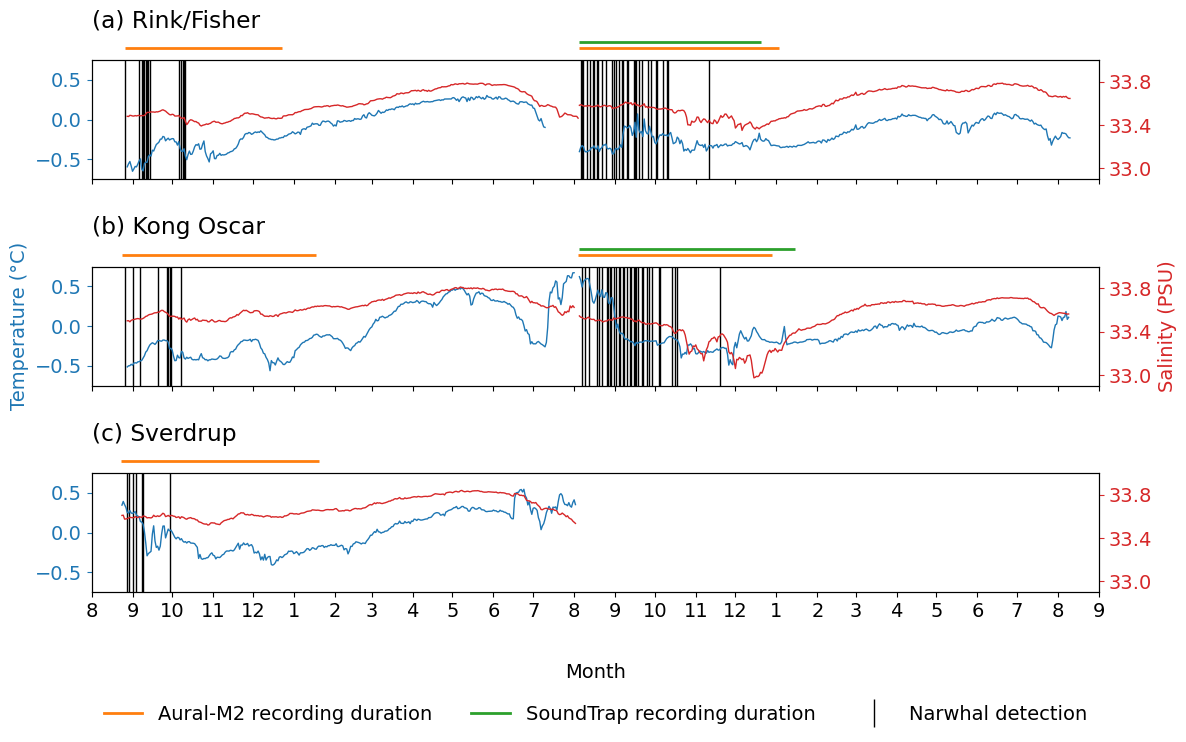

In [113]:
plt.rcParams["figure.figsize"] = (13,4)
plt.rcParams['font.size'] = 14
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8) = plt.subplots(8, sharex=True, sharey=False, gridspec_kw={'height_ratios': [0.6,6,2,0.6,6,2,0.6,6]})

plt.subplots_adjust(top=1.5, hspace=0.2)
ax1.set_xlim(np.datetime64('2018-08-01'), np.datetime64('2020-09-01'))

# RINK/FISHER ====
ax1.set_title("(a) Rink/Fisher", loc='left')
ax1.hlines(y=0, xmin=rink_aural_dates_array[0], xmax=rink_aural_dates_array[-1],linewidth=2, color='tab:orange', clip_on=False)
ax1.hlines(y=0, xmin=fisher_aural_dates_array[0], xmax=fisher_aural_dates_array[-1],linewidth=2, color='tab:orange', clip_on=False)
ax1.hlines(y=50, xmin=fisher_ST_dates_array[0], xmax=np.datetime64('2019-12-20'),linewidth=2, color='tab:green', clip_on=False)
ax1.set_ylim(0,100)
ax1.axis('off')

# add narwhal detections ----
for xcoord in rink_aural_narwhal_dates:
    ax2.axvline(x=xcoord, color='k', linewidth=1)
for xcoord in fisher_ST_narwhal_dates:
    ax2.axvline(x=xcoord, color='k', linewidth=1)

# add temperature
rink_temp_120m_timeseries_da.plot(ax=ax2, c='tab:blue', linewidth=1)
fisher_temp_120m_timeseries_da.plot(ax=ax2, c='tab:blue', linewidth=1)
# rink_temp_220m_timeseries_da.plot(ax=ax2, c='tab:blue', linestyle='dashed', linewidth=1)
# fisher_temp_220m_timeseries_da.plot(ax=ax2, c='tab:blue', linestyle='dashed', linewidth=1)
# ax2.grid(linestyle='--', linewidth=0.5)
ax2.margins(x=0,y=0)
    
# add salinity
ax2_twin = ax2.twinx()
rink_salt_120m_timeseries_da.plot(ax=ax2_twin, c='tab:red', linewidth=1)
fisher_salt_120m_timeseries_da.plot(ax=ax2_twin, c='tab:red', linewidth=1)
# rink_salt_220m_timeseries_da.plot(ax=ax2_twin, c='tab:red', linestyle='dashed', linewidth=1)
# fisher_salt_220m_timeseries_da.plot(ax=ax2_twin, c='tab:red', linestyle='dashed', linewidth=1)

# KONG OSCAR ====
ax3.axis('off') # filler axis
ax4.set_title("(b) Kong Oscar", loc='left')
ax4.hlines(y=0, xmin=KO18_aural_dates_array[0], xmax=KO18_aural_dates_array[-1], linewidth=2, color='tab:orange', clip_on=False, label='Aural start/end')
ax4.hlines(y=0, xmin=KO19_aural_dates_array[0], xmax=KO19_aural_dates_array[-1], linewidth=2, color='tab:orange', clip_on=False, label='Aural start/end')
ax4.hlines(y=50, xmin=KO19_ST_dates_array[0], xmax=KO19_ST_dates_array[-1], linewidth=2, color='tab:green', clip_on=False, label='SoundTrap start/end')
ax4.set_ylim(0,100)
ax4.axis('off')

# add narwhal detections ----
for xcoord in KO18_aural_narwhal_dates:
    ax5.axvline(x=xcoord, color='k', linewidth=1)
for xcoord in KO19_ST_narwhal_dates:
    ax5.axvline(x=xcoord, color='k', linewidth=1)

# add temperature
KO_temp_120m_timeseries_da.plot(ax=ax5, c='tab:blue', linewidth=1)
# KO_temp_220m_timeseries_da.plot(ax=ax5, c='tab:blue', linestyle='dashed', linewidth=1)
ax5.tick_params(axis='y', colors='tab:blue')
ax5.margins(x=0,y=0)
    
# add salinity
ax5_twin = ax5.twinx()
KO_salt_120m_timeseries_da.plot(ax=ax5_twin, c='tab:red', linewidth=1)

# SVERDRUP ====
ax6.axis('off') # filler axis
ax7.set_title("(c) Sverdrup", loc='left')
ax7.hlines(y=0, xmin=sver18_aural_dates_array[0], xmax=sver18_aural_dates_array[-1], linewidth=2, color='tab:orange', clip_on=False, label='Aural start/end')
ax7.set_ylim(0,100)
ax7.axis('off')

# add narwhal detections ----
for xcoord in sver18_aural_narwhal_dates:
    ax8.axvline(x=xcoord, color='k', linewidth=1)
    
# add temperature
sverdrup_temp_120m_timeseries_da.plot(ax=ax8, c='tab:blue', linewidth=1)
# sverdrup_temp_220m_timeseries_da.plot(ax=ax8, c='tab:blue', linestyle='dashed', linewidth=1)
ax8.tick_params(axis='y', colors='tab:gray')
ax8.margins(x=0,y=0)

# add salinity
ax8_twin = ax8.twinx()
sverdrup_salt_120m_timeseries_da.plot(ax=ax8_twin, c='tab:red', linewidth=1)
# sverdrup_salt_220m_timeseries_da.plot(ax=ax8_twin, c='tab:red', linestyle='dashed', linewidth=1)

months   = pd.period_range(np.datetime64('2018-08'), freq='M', periods=26).strftime('%Y-%m').tolist()
# abbrev = ["A","S","O",'N','D',"J",'F','M','A','M','J','J','A',"S","O",'N','D',"J",'F','M','A','M','J','J','A',"S"]
abbrev = ['8','9','10','11','12','1','2','3','4','5','6','7','8','9','10','11','12','1','2','3','4','5','6','7','8','9']
ax8.set_xticks(months, [])
ax8.set_xticks(months, abbrev, rotation=0, horizontalalignment = 'center')

# add legend
legend_elements = [Line2D([0], [0], color='tab:orange', lw=2, label='Aural-M2 recording duration'),
                   Line2D([0], [0], color='tab:green', lw=2, label='SoundTrap recording duration'),
                   Line2D([], [], marker='|', linestyle='None',color='k', lw=1,markersize=20, label='Narwhal detection')]
ax8.legend(handles=legend_elements, loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.8),frameon=False)

# params for y-axis
for ax in (ax2,ax5,ax8):
    ax.tick_params(axis='y', colors='tab:blue')
    ax.set_ylim(-0.75,0.75)
    ax.set_xlabel("")
    ax.set_ylabel("")
    # ax.axhline(y=mooring_temp_120m_mean)
for ax in (ax2_twin,ax5_twin,ax8_twin):
    ax.set_yticks([33,33.4,33.8])
    ax.margins(x=0,y=0)
    ax.set_ylim(32.9,34)
    ax.set_ylabel("")
    ax.tick_params(axis='y', colors='tab:red')
ax5_twin.set_ylabel("Salinity (PSU)", color='tab:red')
ax5.set_ylabel("Temperature (°C)", color='tab:blue')

ax8.set_xlabel("Month",labelpad=30);

plt.savefig('figures/narwhal-dets_temp-salt-surf.png', bbox_inches='tight', dpi=300, facecolor='white')

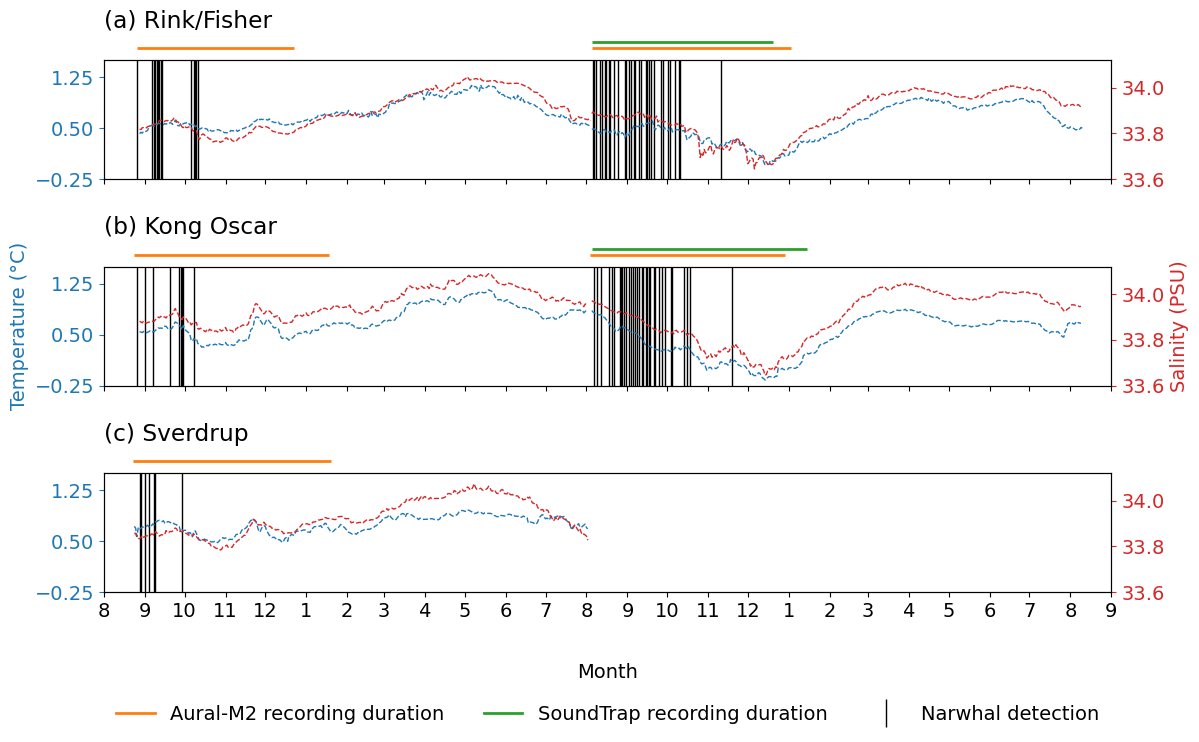

In [114]:
plt.rcParams["figure.figsize"] = (13,4)
plt.rcParams['font.size'] = 14
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8) = plt.subplots(8, sharex=True, sharey=False, gridspec_kw={'height_ratios': [0.6,6,2,0.6,6,2,0.6,6]})

plt.subplots_adjust(top=1.5, hspace=0.2)
ax1.set_xlim(np.datetime64('2018-08-01'), np.datetime64('2020-09-01'))

# RINK/FISHER ====
ax1.set_title("(a) Rink/Fisher", loc='left')
ax1.hlines(y=0, xmin=rink_aural_dates_array[0], xmax=rink_aural_dates_array[-1],linewidth=2, color='tab:orange', clip_on=False)
ax1.hlines(y=0, xmin=fisher_aural_dates_array[0], xmax=fisher_aural_dates_array[-1],linewidth=2, color='tab:orange', clip_on=False)
ax1.hlines(y=50, xmin=fisher_ST_dates_array[0], xmax=np.datetime64('2019-12-20'),linewidth=2, color='tab:green', clip_on=False)
ax1.set_ylim(0,100)
ax1.axis('off')

# add narwhal detections ----
for xcoord in rink_aural_narwhal_dates:
    ax2.axvline(x=xcoord, color='k', linewidth=1)
for xcoord in fisher_ST_narwhal_dates:
    ax2.axvline(x=xcoord, color='k', linewidth=1)

# add temperature
rink_temp_220m_timeseries_da.plot(ax=ax2, c='tab:blue', linestyle='dashed', linewidth=1)
fisher_temp_220m_timeseries_da.plot(ax=ax2, c='tab:blue', linestyle='dashed', linewidth=1)
# ax2.grid(linestyle='--', linewidth=0.5)
ax2.margins(x=0,y=0)
    
# add salinity
ax2_twin = ax2.twinx()
rink_salt_220m_timeseries_da.plot(ax=ax2_twin, c='tab:red', linestyle='dashed', linewidth=1)
fisher_salt_220m_timeseries_da.plot(ax=ax2_twin, c='tab:red', linestyle='dashed', linewidth=1)

# KONG OSCAR ====
ax3.axis('off') # filler axis
ax4.set_title("(b) Kong Oscar", loc='left')
ax4.hlines(y=0, xmin=KO18_aural_dates_array[0], xmax=KO18_aural_dates_array[-1], linewidth=2, color='tab:orange', clip_on=False, label='Aural start/end')
ax4.hlines(y=0, xmin=KO19_aural_dates_array[0], xmax=KO19_aural_dates_array[-1], linewidth=2, color='tab:orange', clip_on=False, label='Aural start/end')
ax4.hlines(y=50, xmin=KO19_ST_dates_array[0], xmax=KO19_ST_dates_array[-1], linewidth=2, color='tab:green', clip_on=False, label='SoundTrap start/end')
ax4.set_ylim(0,100)
ax4.axis('off')

# add narwhal detections ----
for xcoord in KO18_aural_narwhal_dates:
    ax5.axvline(x=xcoord, color='k', linewidth=1)
for xcoord in KO19_ST_narwhal_dates:
    ax5.axvline(x=xcoord, color='k', linewidth=1)

# add temperature
KO_temp_220m_timeseries_da.plot(ax=ax5, c='tab:blue', linestyle='dashed', linewidth=1)
ax5.tick_params(axis='y', colors='tab:blue')
ax5.margins(x=0,y=0)
    
# add salinity
ax5_twin = ax5.twinx()
KO_salt_220m_timeseries_da.plot(ax=ax5_twin, c='tab:red', linestyle='dashed', linewidth=1)

# SVERDRUP ====
ax6.axis('off') # filler axis
ax7.set_title("(c) Sverdrup", loc='left')
ax7.hlines(y=0, xmin=sver18_aural_dates_array[0], xmax=sver18_aural_dates_array[-1], linewidth=2, color='tab:orange', clip_on=False, label='Aural start/end')
ax7.set_ylim(0,100)
ax7.axis('off')

# add narwhal detections ----
for xcoord in sver18_aural_narwhal_dates:
    ax8.axvline(x=xcoord, color='k', linewidth=1)
    
# add temperature
sverdrup_temp_220m_timeseries_da.plot(ax=ax8, c='tab:blue', linestyle='dashed', linewidth=1)
ax8.tick_params(axis='y', colors='tab:gray')
ax8.margins(x=0,y=0)

# add salinity
ax8_twin = ax8.twinx()
sverdrup_salt_220m_timeseries_da.plot(ax=ax8_twin, c='tab:red', linestyle='dashed', linewidth=1)

months   = pd.period_range(np.datetime64('2018-08'), freq='M', periods=26).strftime('%Y-%m').tolist()
# abbrev = ["A","S","O",'N','D',"J",'F','M','A','M','J','J','A',"S","O",'N','D',"J",'F','M','A','M','J','J','A',"S"]
abbrev = ['8','9','10','11','12','1','2','3','4','5','6','7','8','9','10','11','12','1','2','3','4','5','6','7','8','9']
ax8.set_xticks(months, [])
ax8.set_xticks(months, abbrev, rotation=0, horizontalalignment = 'center')

# add legend
legend_elements = [Line2D([0], [0], color='tab:orange', lw=2, label='Aural-M2 recording duration'),
                   Line2D([0], [0], color='tab:green', lw=2, label='SoundTrap recording duration'),
                   Line2D([], [], marker='|', linestyle='None',color='k', lw=1,markersize=20, label='Narwhal detection')]
ax8.legend(handles=legend_elements, loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.8),frameon=False)

# params for y-axis
for ax in (ax2,ax5,ax8):
    ax.tick_params(axis='y', colors='tab:blue')
    ax.set_yticks([-0.25,0.5,1.25])
    ax.set_ylim(-0.25,1.5)
    ax.set_xlabel("")
    ax.set_ylabel("")
    # ax.axhline(y=mooring_temp_120m_mean)
for ax in (ax2_twin,ax5_twin,ax8_twin):
    ax.set_yticks([33.6,33.8,34])
    ax.margins(x=0,y=0)
    ax.set_ylim(33.6,34.12)
    ax.set_ylabel("")
    ax.tick_params(axis='y', colors='tab:red')
ax5_twin.set_ylabel("Salinity (PSU)", color='tab:red')
ax5.set_ylabel("Temperature (°C)", color='tab:blue')

ax8.set_xlabel("Month",labelpad=30);

plt.savefig('figures/narwhal-dets_temp-salt-deep.png', bbox_inches='tight', dpi=300, facecolor='white')

### Plot 2019 narwhal detections with DOY and temp/salt data

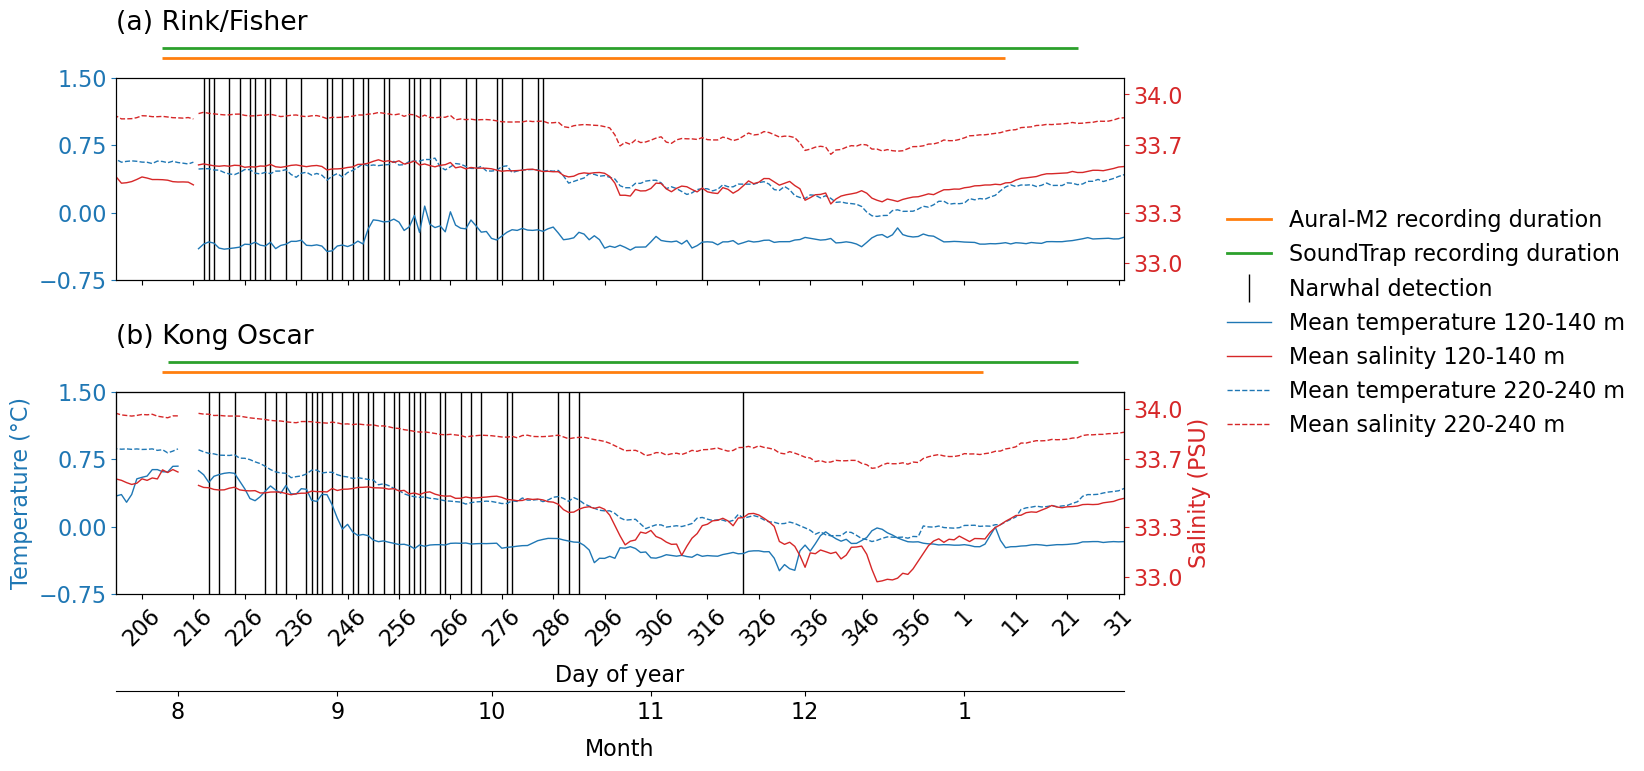

In [115]:
plt.rcParams["figure.figsize"] = (13,4)
plt.rcParams['font.size'] = 16
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, gridspec_kw={'height_ratios': [0.6,6,1,0.6,6]})

plt.subplots_adjust(top=1.5, hspace=0.2)

# RINK/FISHER ====
ax1.set_title("(a) Rink/Fisher", loc='left')
ax1.hlines(y=0, xmin=fisher_aural_dates_array[0], xmax=fisher_aural_dates_array[-1],linewidth=2, color='tab:orange', clip_on=False)
ax1.hlines(y=50, xmin=fisher_ST_dates_array[0], xmax=fisher_ST_dates_array[-1],linewidth=2, color='tab:green', clip_on=False)
ax1.set_ylim(0,100)
ax1.axis('off')

# add narwhal detections ----
for xcoord in fisher_ST_narwhal_dates:
    ax2.axvline(x=xcoord, color='k', linewidth=1)

# add temperature
rink_temp_120m_timeseries_da.plot(ax=ax2, c='tab:blue', linestyle='-', linewidth=1)
fisher_temp_120m_timeseries_da.plot(ax=ax2, c='tab:blue', linestyle='-', linewidth=1)
rink_temp_220m_timeseries_da.plot(ax=ax2, c='tab:blue', linestyle='dashed', linewidth=1)
fisher_temp_220m_timeseries_da.plot(ax=ax2, c='tab:blue', linestyle='dashed', linewidth=1)
# ax2.grid(linestyle='--', linewidth=0.5)
ax2.margins(x=0,y=0)
    
# add salinity
ax2_twin = ax2.twinx()
rink_salt_120m_timeseries_da.plot(ax=ax2_twin, c='tab:red', linestyle='-', linewidth=1)
fisher_salt_120m_timeseries_da.plot(ax=ax2_twin, c='tab:red', linestyle='-', linewidth=1)
rink_salt_220m_timeseries_da.plot(ax=ax2_twin, c='tab:red', linestyle='dashed', linewidth=1)
fisher_salt_220m_timeseries_da.plot(ax=ax2_twin, c='tab:red', linestyle='dashed', linewidth=1)

# KONG OSCAR ====
ax3.axis('off') # filler axis
ax4.set_title("(b) Kong Oscar", loc='left')
ax4.hlines(y=0, xmin=KO19_aural_dates_array[0], xmax=KO19_aural_dates_array[-1], linewidth=2, color='tab:orange', clip_on=False, label='Aural start/end')
ax4.hlines(y=50, xmin=KO19_ST_dates_array[0], xmax=KO19_ST_dates_array[-1], linewidth=2, color='tab:green', clip_on=False, label='SoundTrap start/end')
ax4.set_ylim(0,100)
ax4.axis('off')

# add narwhal detections ----
for xcoord in KO19_ST_narwhal_dates:
    ax5.axvline(x=xcoord, color='k', linewidth=1)

# add temperature
KO_temp_120m_timeseries_da.plot(ax=ax5, c='tab:blue', linestyle='-', linewidth=1)
KO_temp_220m_timeseries_da.plot(ax=ax5, c='tab:blue', linestyle='dashed', linewidth=1)
ax5.tick_params(axis='y', colors='tab:blue')
ax5.margins(x=0,y=0)
    
# add salinity
ax5_twin = ax5.twinx()
KO_salt_120m_timeseries_da.plot(ax=ax5_twin, c='tab:red', linestyle='-', linewidth=1)
KO_salt_220m_timeseries_da.plot(ax=ax5_twin, c='tab:red', linestyle='dashed', linewidth=1)

# add legend
legend_elements = [Line2D([0], [0], color='tab:orange', lw=2, label='Aural-M2 recording duration'),
                   Line2D([0], [0], color='tab:green', lw=2, label='SoundTrap recording duration'),
                   Line2D([], [], marker='|', linestyle='None',color='k', lw=1,markersize=20, label='Narwhal detection'),
                   Line2D([0], [0], color='tab:blue', lw=1, label='Mean temperature 120-140 m'),
                   Line2D([0], [0], color='tab:red', lw=1, label='Mean salinity 120-140 m'),
                   Line2D([0], [0], color='tab:blue', linestyle='dashed', lw=1, label='Mean temperature 220-240 m'),
                   Line2D([0], [0], color='tab:red', linestyle='dashed', lw=1, label='Mean salinity 220-240 m')]
ax5.legend(handles=legend_elements, loc='upper center', ncol=1, bbox_to_anchor=(1.3, 2),frameon=False)
# ax5.legend(handles=legend_elements, loc='upper center', ncol=1, bbox_to_anchor=(0.5, -0.8),frameon=False)

# params for axes
days   = pd.period_range(np.datetime64('2019-07-05'), freq='10D', periods=22).strftime('%Y-%m-%d').tolist()
## take days used in x-axis and convert to day of year (DOY)
DOY = []
for day in days:
    DOY.append(datetime.strptime(day, '%Y-%m-%d').timetuple().tm_yday)
ax2.set_xticks(days, [])
ax5.set_xticks(days, DOY, rotation=45, horizontalalignment = 'center')

for ax in (ax2,ax5):
    ax.tick_params(axis='y', colors='tab:blue')
    ax.set_yticks([-0.75,0,0.75,1.5])
    ax.set_ylim(-0.75,1.5)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xlim(np.datetime64('2019-07-20'), np.datetime64('2020-02-01'))
for ax in (ax2_twin,ax5_twin):
    ax.set_yticks([33,33.3,33.7,34])
    ax.margins(x=0,y=0)
    ax.set_ylim(32.9,34.1)
    ax.set_ylabel("")
    ax.tick_params(axis='y', colors='tab:red')
ax5_twin.set_ylabel("Salinity (PSU)", color='tab:red')
ax5.set_ylabel("Temperature (°C)", color='tab:blue')

ax5.set_xlabel("Day of year",labelpad=10);

## add second x axis
month_days   = pd.period_range(np.datetime64('2019-08'), freq='1M', periods=6).strftime('%Y-%m').tolist()
label = ['8','9','10','11','12','1']
ax6 = ax5.twiny()
ax6.set_xticks(np.array(month_days, dtype='datetime64'))
ax6.set_xticklabels(label)
ax6.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax6.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax6.spines['bottom'].set_position(('outward', 70))
ax6.set_xlim(np.datetime64('2019-07-20'), np.datetime64('2020-02-01'))
ax6.set_xlabel("Month",labelpad=10);

plt.savefig('figures/narwhal-dets_temp-salt_zoom.png', bbox_inches='tight', dpi=300, facecolor='white')